In [1]:
import os
import sys
import glob
import json

import torch
import numpy as np
from pathlib import Path
import torchvision
from torchvision import transforms
from einops import rearrange

import matplotlib.pyplot as plt

from PIL import Image

Matplotlib created a temporary cache directory at /tmp/matplotlib-j94vi77i because the default path (/home/user/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [20]:
data_root_o = '/nas/exchange/objaverse/objaverse'#'/objaverse' #'../objaverse-rendering/rendering/output/'

class ObjaverseDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, validation=False, load_view=8, total_view=12):
        self.data_root = Path(data_root)
        self.validation = validation
        self.load_view = load_view
        print('load view:', load_view)
        self.total_view = total_view
        self.opengl_to_colmap = torch.tensor([[  1,  0,  0,  0],
                                              [  0, -1,  0,  0],
                                              [  0,  0, -1,  0],
                                              [  0,  0,  0,  1]], dtype=torch.float32)

        image_transforms = [
            torchvision.transforms.Resize(256),
            transforms.ToTensor(),
            #transforms.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))
            transforms.Lambda(self.rearrange_func)
        ]
        self.image_transforms = transforms.Compose(image_transforms)

    def load_im(self, path, color):
        '''
        replace background pixel with random color in rendering
        '''
        try:
            img = plt.imread(path)
        except:
            print(path)
            #os.remove(path)
            #os.remove(path.replace('png', 'npy'))
            sys.exit()
        img[img[:, :, -1] == 0.] = color
        img = Image.fromarray(np.uint8(img[:, :, :3] * 255.))
        return img

    def rearrange_func(self, x):
            return rearrange(x * 2. - 1., 'c h w -> h w c')
    
    def process_img(self, img):
        img = img.convert("RGB")
        return self.image_transforms(img)
    

    


    def pre_data(self, paths, views):
            '''
            load the data for given filename 
            '''
            color = [1., 1., 1., 1.]
            imgs = []
            w2cs = []
            intrinsics = []
            index = range(views) if self.validation else torch.randperm(views)
            # # find the closer views
            for i in index[:self.load_view]:
                img = self.process_img(self.load_im(paths[i], color)).unsqueeze(0)
                imgs.append(img)
                
                w2c_gl = np.load(paths[i].replace('png', 'npy'))
                w2cs.append(w2c_gl)
                focal = .5 / np.tan(.5 * 0.8575560450553894)
                intrinsics.append(np.array([[focal, 0.0, 1.0 / 2.0],
                                            [0.0, focal, 1.0 / 2.0],
                                            [0.0, 0.0, 1.0]]))
            imgs = torch.cat(imgs)
            intrinsics = torch.tensor(np.array(intrinsics)).to(imgs)
            w2cs = torch.tensor(np.array(w2cs)).to(imgs)
            w2cs_gl = torch.eye(4).unsqueeze(0).repeat(imgs.size(0),1,1)
            w2cs_gl[:,:3,:] = w2cs
            # camera poses in .npy files are in OpenGL convention: 
            #     x right, y up, z into the camera (backward),
            # need to transform to COLMAP / OpenCV:
            #     x right, y down, z away from the camera (forward)



            w2cs = torch.einsum('nj, bjm-> bnm', self.opengl_to_colmap, w2cs_gl)
            c2ws = torch.linalg.inv(w2cs)
            camera_centers = c2ws[:, :3, 3].clone()
            # fix the distance of the source camera to the object / world center
            assert torch.norm(camera_centers[0]) > 1e-5
            translation_scaling_factor = 2.0 / torch.norm(camera_centers[0])
            w2cs[:, :3, 3] *= translation_scaling_factor
            c2ws[:, :3, 3] *= translation_scaling_factor
            camera_centers *= translation_scaling_factor
            return imgs, w2cs, c2ws, intrinsics

In [6]:
from utils.vis_camera import frustums2lineset


from utils.vis_camera import get_camera_frustum
from skimage.transform import downscale_local_mean

import scenepic as sp
from utils.webvis import default_camera


def vis_points_images_cameras(W2C, K, imgs, pts=None, rgb=None, frustum_size=0.5, nth=1, filename='index.html'):
    # represent the scene
    scene = sp.Scene()
    # visualize cameras and imgs
    frustums = []
    img_meshes = []
    b, h, w, c = imgs.size()
    for i in range(0, b, nth):
        # read camera
        frustum = get_camera_frustum((h, w), K[i], W2C[i], frustum_length=frustum_size)
        # read image
        texture_id = f"frame_{i:02}"
        img = scene.create_image(image_id=texture_id)
        # read image
        img_data = (imgs[i].numpy() + 1) / 2.0
        img_data_scaled = downscale_local_mean(img_data, (2,2,1))
        img.from_numpy(img_data_scaled)
        frustum_points = frustum[0]
        frustum_image_points = frustum_points[1:, :]
        # build the mesh
        img_mesh = scene.create_mesh(texture_id=texture_id)
        img_mesh.double_sided = True
        img_mesh.add_mesh_without_normals(
            frustum_image_points,
            np.array([[0, 2, 1], [0, 3, 2]], dtype=np.uint32),
            uvs=np.array([[0, 1], [1, 1], [1, 0], [0, 0]], dtype=np.float32)
        )
        img_meshes.append(img_mesh)
        frustums.append(frustum)
    points, lines, colors = frustums2lineset(frustums)
    lines = lines.astype(np.int64)
    cam_meshes = scene.create_mesh(shared_color=sp.Color(0.0, 1.0, 0.0))
    cam_meshes.add_lines(
        start_points=points[lines[:, 0], :],
        end_points=points[lines[:, 1], :]
    )
    if pts is not None and rgb is not None:
        point_mesh = scene.create_mesh("mesh")
        point_mesh.shared_color = np.array([0.7, 0.7, 0.7])
        point_mesh.add_cube()
        point_mesh.apply_transform(sp.Transforms.Scale(0.002))
        point_mesh.enable_instancing(positions=pts, colors=rgb)
        all_meshes = [point_mesh] + img_meshes + [cam_meshes]
    else:
        all_meshes = img_meshes + [cam_meshes]
    # output the visualized results to html
    main = scene.create_canvas_3d(width=1600, height=1600,
                                  shading=sp.Shading(bg_color=sp.Colors.White))
    main.camera = default_camera()
    # visualize the results
    frame1 = main.create_frame(meshes=all_meshes)
    scene.save_as_html(filename, title=filename.split('.')[0])

In [35]:
data_root_o = '/nas/exchange/objaverse/objaverse'#'/objaverse' #'../objaverse-rendering/rendering/output/'
data = ObjaverseDataset(data_root_o)

filename = os.path.join(data_root_o, '7f3cdc053c064387802b6f4eefeaa97a')
paths = glob.glob(filename + '/*.png')
views = len(paths)

print(views, paths)

imgs_o, w2cs_o, c2ws_o, intrinsics_o = data.pre_data(paths, views)

load view: 8
12 ['/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/007.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/006.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/008.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/002.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/004.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/011.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/003.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/005.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/001.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/009.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/000.png', '/nas/exchange/objaverse/objaverse/7f3cdc053c064387802b6f4eefeaa97a/010.png']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


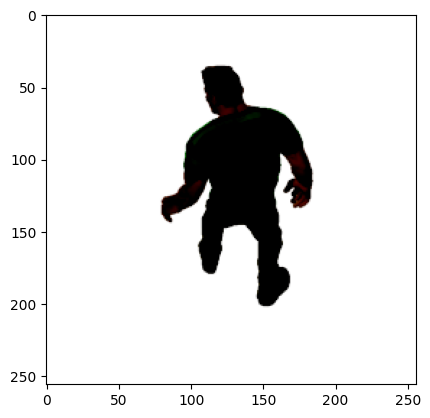

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


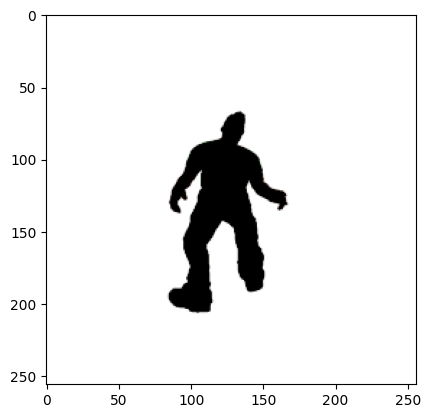

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


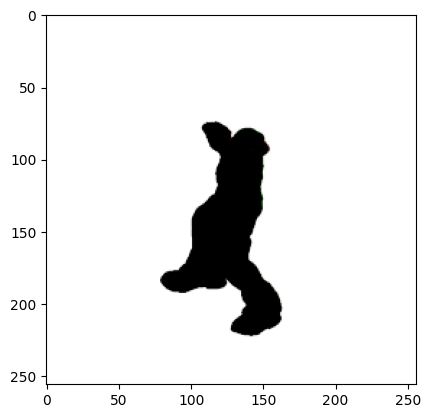

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


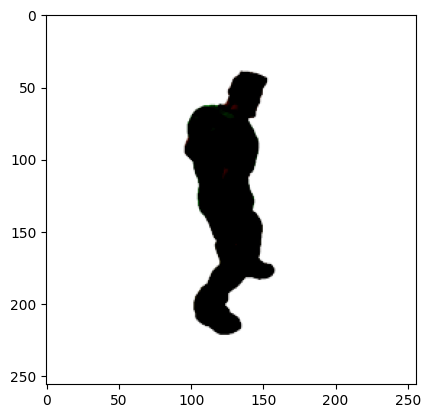

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


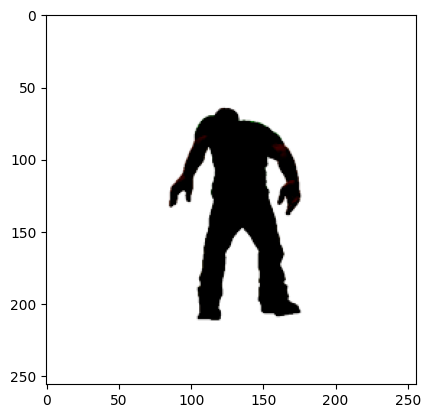

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


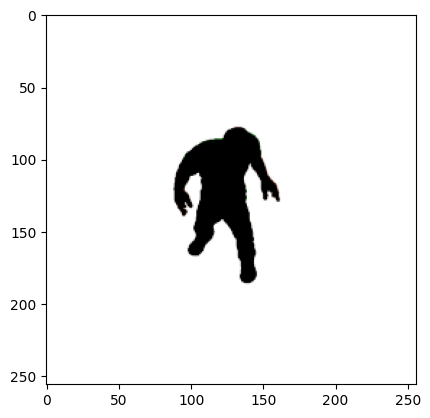

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


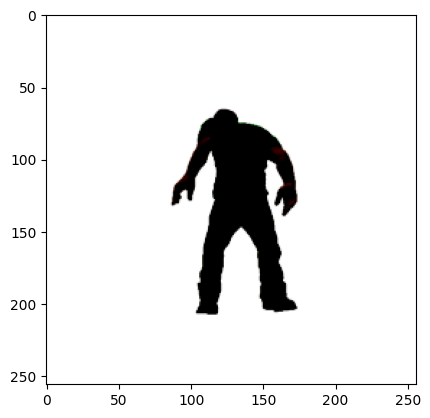

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


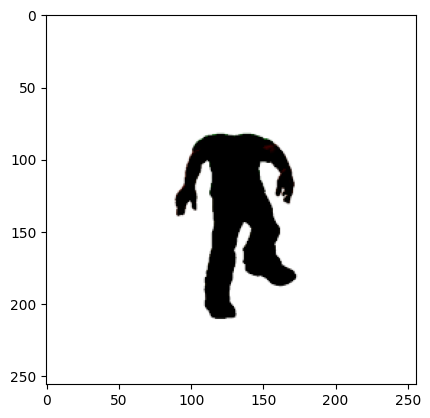

In [36]:
import matplotlib.pyplot as plt

# Assuming imgs is a list of images
for img in imgs_o:
    plt.imshow(img)
    plt.show()

plt.show()

In [37]:
intrinsics_o[:, 0, :] *=256
intrinsics_o[:, 1, :] *=256
vis_points_images_cameras(w2cs_o, intrinsics_o, imgs_o, frustum_size=0.5, filename='index_o.html')

In [11]:

import numpy as np
from scipy.linalg import svd


class ObjaverseSkelDataset(ObjaverseDataset):  

    def pre_data(self, paths, views):
        '''
        load the data for given filename 
        '''
        color = [1., 1., 1., 1.]
        imgs = []
        skels = []
        w2cs = []
        intrinsics = []
        index = range(views) if self.validation else torch.randperm(views)
        # # find the closer views
        for i in index[:self.load_view]:
            img = self.process_img(self.load_im(paths[i], color)).unsqueeze(0)
            imgs.append(img)

            skel = self.process_img(self.load_im(paths[i].replace('step_view', 'step_skel_view'), color)).unsqueeze(0)
            skels.append(skel)    
            
            metadata = json.load(open(paths[i].replace('step_view', 'random').replace('.png', '.json')))
            
            '''
            mmm = np.array(metadata['matrix_world'])
            rotation = mmm[:3, :3]
            # Extract the translation vector (top-right 3x1 subvector)
            translation = mmm[:3, 3]
            R_world2bcam = rotation.T
            # Use location from matrix_world to account for constraints:
            T_world2bcam = -1 * R_world2bcam @ translation
            # put into 3x4 matrix            
            w2c_gl = np.column_stack((R_world2bcam, T_world2bcam))

            '''
            w2c_gl = np.array(metadata['matrix_world_RT'])
            w2cs.append(w2c_gl)
            #w2c_gl = np.array(metadata['matrix_world'])
            #w2c_gl = np.load(paths[i].replace('png', 'npy'))     
            # 


            focal = .5 / np.tan(.5 * metadata['x_fov'])
            intrinsics.append(np.array([[focal, 0.0, 1.0 / 2.0],
                                        [0.0, focal, 1.0 / 2.0],
                                        [0.0, 0.0, 1.0]]))

            #intrinsics.append(np.array(metadata['matrix_world_K']))
        imgs = torch.cat(imgs)
        skels = torch.cat(skels)
        intrinsics = torch.tensor(np.array(intrinsics)).to(imgs)
        w2cs = torch.tensor(np.array(w2cs)).to(imgs)
        w2cs_gl = torch.eye(4).unsqueeze(0).repeat(imgs.size(0),1,1)
        w2cs_gl[:,:3,:] = w2cs

        w2cs = torch.einsum('nj, bjm-> bnm', self.opengl_to_colmap, w2cs_gl)
        c2ws = torch.linalg.inv(w2cs)
        camera_centers = c2ws[:, :3, 3].clone()
        # fix the distance of the source camera to the object / world center
        assert torch.norm(camera_centers[0]) > 1e-5
        translation_scaling_factor = 2.0 / torch.norm(camera_centers[0])
        w2cs[:, :3, 3] *= translation_scaling_factor
        c2ws[:, :3, 3] *= translation_scaling_factor
        camera_centers *= translation_scaling_factor
        return imgs, skels, w2cs, c2ws, intrinsics
     

    

In [39]:
data_root = '../objaverse-rendering/rendering/output4/'

data = ObjaverseSkelDataset(data_root)
paths = []
frames = os.path.join(data_root, '7f3cdc053c064387802b6f4eefeaa97a')
for f in os.listdir(frames)[:2]:    
    paths += glob.glob(os.path.join(frames, f, 'step_view*.png'))
views = len(paths)


imgs, skels,  w2cs, c2ws, intrinsics = data.pre_data(paths, views)

load view: 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


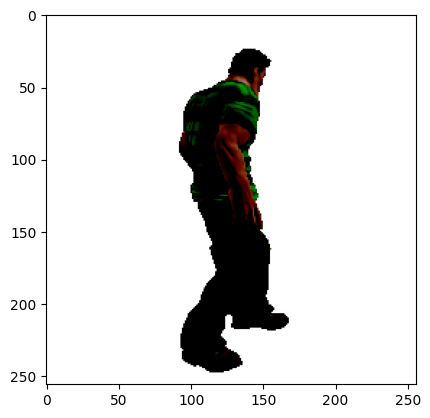

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


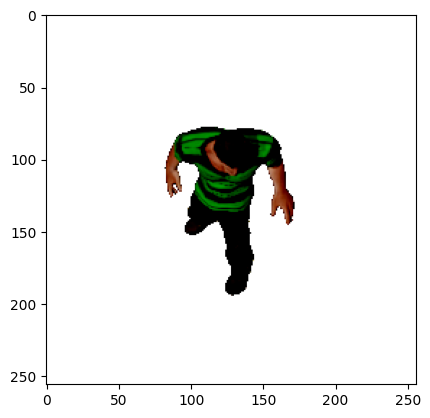

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


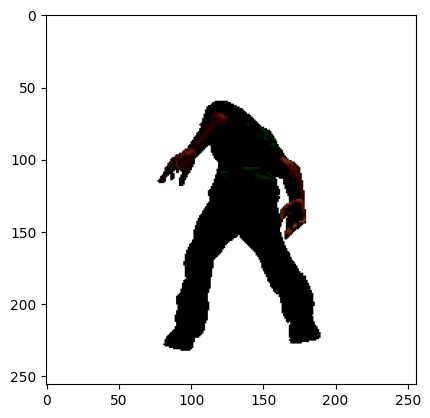

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


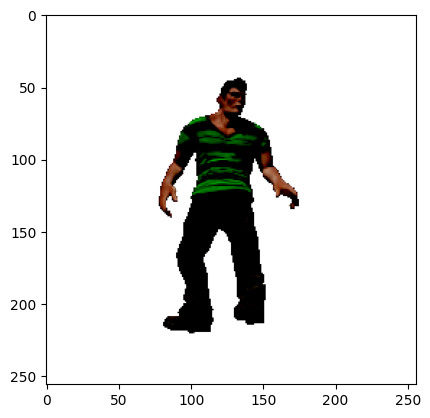

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


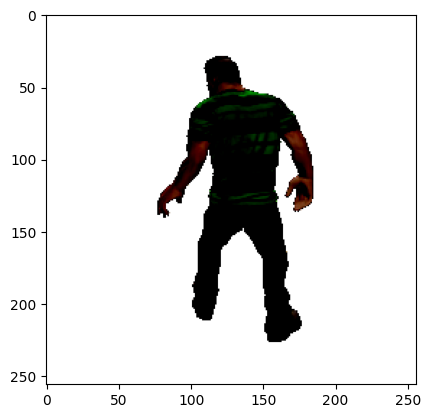

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


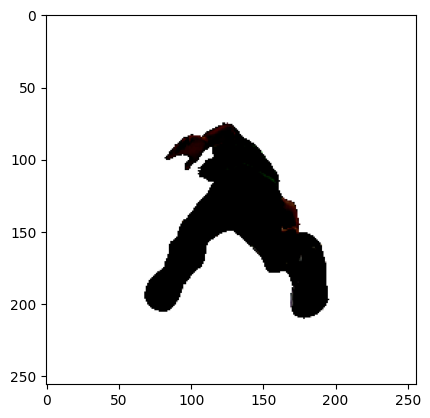

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


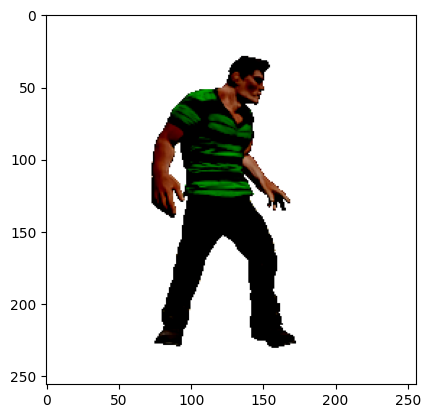

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


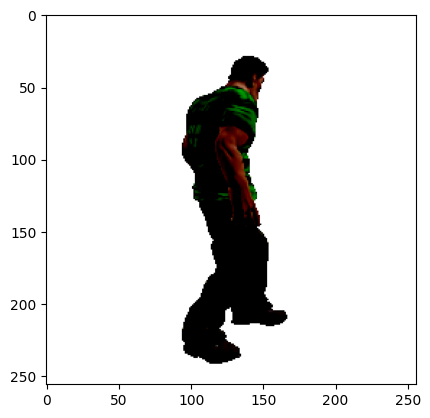

In [40]:
for img in imgs:
    plt.imshow(img)
    plt.show()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


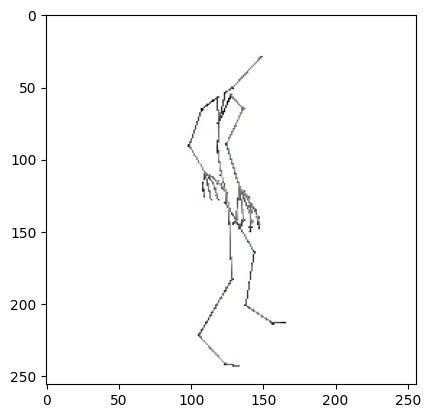

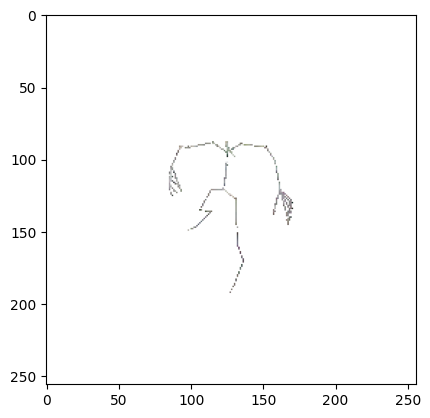

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


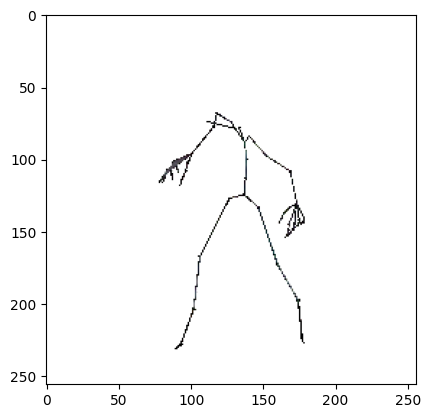

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


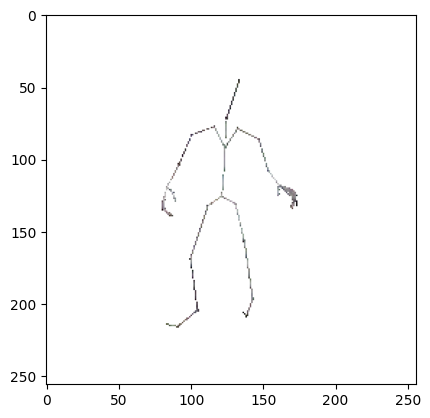

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


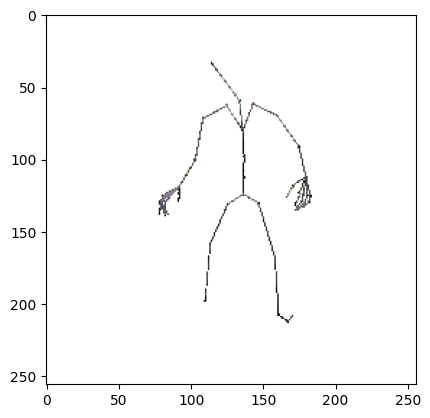

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


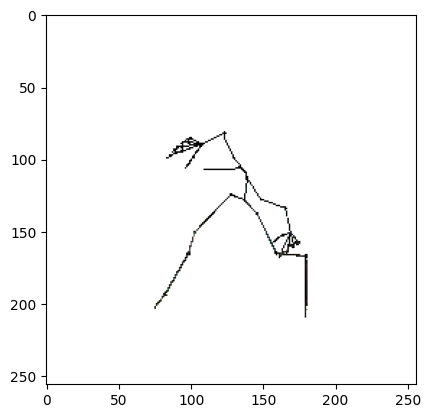

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


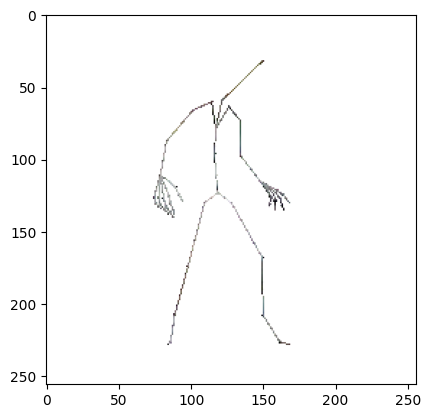

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


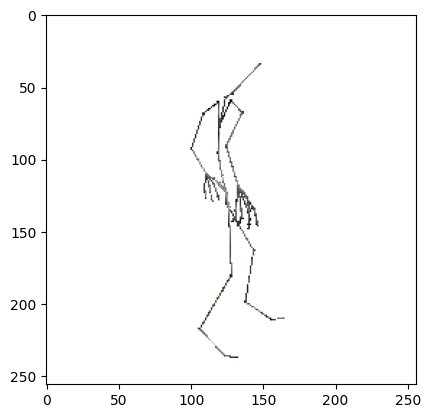

In [41]:
for skel in skels:
    plt.imshow(skel)
    plt.show()

plt.show()

In [42]:
intrinsics[:, 0, :] *= 256
intrinsics[:, 1, :] *= 256
vis_points_images_cameras(w2cs, intrinsics, imgs, frustum_size=0.5)

In [ ]:
def get_3x4_RT_matrix_from_blender():

    cam = bpy.context.scene.camera
    # bcam stands for blender camera
    # R_bcam2cv = Matrix(
    #     ((1, 0,  0),
    #     (0, 1, 0),
    #     (0, 0, 1)))

    # Transpose since the rotation is object rotation, 
    # and we want coordinate rotation
    # R_world2bcam = cam.rotation_euler.to_matrix().transposed()
    # T_world2bcam = -1*R_world2bcam @ location
    #
    # Use matrix_world instead to account for all constraints
    location, rotation = cam.matrix_world.decompose()[0:2]
    R_world2bcam = rotation.to_matrix().transposed()

    # Convert camera location to translation vector used in coordinate changes
    # T_world2bcam = -1*R_world2bcam @ cam.location
    # Use location from matrix_world to account for constraints:     
    T_world2bcam = -1*R_world2bcam @ location

    # # Build the coordinate transform matrix from world to computer vision camera
    # R_world2cv = R_bcam2cv@R_world2bcam
    # T_world2cv = R_bcam2cv@T_world2bcam

    # put into 3x4 matrix
    RT = Matrix((
        R_world2bcam[0][:] + (T_world2bcam[0],),
        R_world2bcam[1][:] + (T_world2bcam[1],),
        R_world2bcam[2][:] + (T_world2bcam[2],)
        ))
    return RT

def scene_fov():
    x_fov = bpy.context.scene.camera.data.angle_x
    y_fov = bpy.context.scene.camera.data.angle_y
    width = bpy.context.scene.render.resolution_x
    height = bpy.context.scene.render.resolution_y
    if bpy.context.scene.camera.data.angle == x_fov:
        y_fov = 2 * math.atan(math.tan(x_fov / 2) * height / width)
    else:
        x_fov = 2 * math.atan(math.tan(y_fov / 2) * width / height)
    return x_fov, y_fov

def scene_bbox(
    single_obj: Optional[bpy.types.Object] = None, ignore_matrix: bool = False
) -> Tuple[Vector, Vector]:
    """Returns the bounding box of the scene.

    Taken from Shap-E rendering script
    (https://github.com/openai/shap-e/blob/main/shap_e/rendering/blender/blender_script.py#L68-L82)

    Args:
        single_obj (Optional[bpy.types.Object], optional): If not None, only computes
            the bounding box for the given object. Defaults to None.
        ignore_matrix (bool, optional): Whether to ignore the object's matrix. Defaults
            to False.

    Raises:
        RuntimeError: If there are no objects in the scene.

    Returns:
        Tuple[Vector, Vector]: The minimum and maximum coordinates of the bounding box.
    """
    bbox_min = (math.inf,) * 3
    bbox_max = (-math.inf,) * 3
    found = False
    for obj in get_scene_meshes() if single_obj is None else [single_obj]:
        found = True
        for coord in obj.bound_box:
            coord = Vector(coord)
            if not ignore_matrix:
                coord = obj.matrix_world @ coord
            bbox_min = tuple(min(x, y) for x, y in zip(bbox_min, coord))
            bbox_max = tuple(max(x, y) for x, y in zip(bbox_max, coord))

    if not found:
        raise RuntimeError("no objects in scene to compute bounding box for")

    return Vector(bbox_min), Vector(bbox_max)

def write_camera_metadata():
    x_fov, y_fov = scene_fov()
    bbox_min, bbox_max = scene_bbox()
    matrix = bpy.context.scene.camera.matrix_world
    matrix_world_np = np.array(matrix)
    
    return dict(
                matrix_world=matrix_world_np.tolist(),
                format_version=6,
                max_depth=5.0,
                bbox=[list(bbox_min), list(bbox_max)],
                origin=list(matrix.col[3])[:3],
                x_fov=x_fov,
                y_fov=y_fov,
                x=list(matrix.col[0])[:3],
                y=list(-matrix.col[1])[:3],
                z=list(-matrix.col[2])[:3],
            )


def pre_data_test(img):
        '''
        load the data for given filename 
        '''
        color = [1., 1., 1., 1.]
        imgs = []
        w2cs = []
        intrinsics = []
        
        img
        imgs.append(img)
        
        w2c_gl = get_3x4_RT_matrix_from_blender()
        w2cs.append(w2c_gl)
        focal = .5 / np.tan(.5 * 0.8575560450553894)
        intrinsics.append(np.array([[focal, 0.0, 1.0 / 2.0],
                                    [0.0, focal, 1.0 / 2.0],
                                    [0.0, 0.0, 1.0]]))
        imgs = torch.cat(imgs)imgs, skels,  w2cs, c2ws, intrinsics
        w2cs_gl = torch.eye(4).unsqueeze(0).repeat(imgs.size(0),1,1)
        w2cs_gl[:,:3,:] = w2cs
        # camera poses in .npy files are in OpenGL convention: 
        #     x right, y up, z into the camera (backward),
        # need to transform to COLMAP / OpenCV:
        #     x right, y down, z away from the camera (forward)

        opengl_to_colmap = torch.tensor([[  1,  0,  0,  0],
                                              [  0, -1,  0,  0],
                                              [  0,  0, -1,  0],
                                              [  0,  0,  0,  1]], dtype=torch.float32)

        w2cs = torch.einsum('nj, bjm-> bnm', opengl_to_colmap, w2cs_gl)
        c2ws = torch.linalg.inv(w2cs)
        camera_centers = c2ws[:, :3, 3].clone()
        # fix the distance of the source camera to the object / world center
        assert torch.norm(camera_centers[0]) > 1e-5
        translation_scaling_factor = 2.0 / torch.norm(camera_centers[0])
        w2cs[:, :3, 3] *= translation_scaling_factor
        c2ws[:, :3, 3] *= translation_scaling_factor
        camera_centers *= translation_scaling_factor
        return imgs, w2cs, c2ws, intrinsics

In [27]:
import os
import json

def list_folders_and_write_to_json(path):
    folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    #valid_paths = {"valid_skel_paths": folders}
    
    with open("valid_skel_paths.json", "w") as json_file:
        json.dump(folders, json_file)
    
    print("Folder names written to valid_skel_paths.json file.")



list_folders_and_write_to_json('/home/user/objaverse-rendering/rendering/output3/')

Folder names written to valid_skel_paths.json file.
